In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_zurich/train/merger/587739097519292568.jpeg  
  inflating: dataset_zurich/train/merger/587736942527643944.jpeg  
  inflating: dataset_zurich/train/merger/588007004191588455.jpeg  
  inflating: dataset_zurich/train/merger/587738953106849840.jpeg  
  inflating: dataset_zurich/train/merger/587739721898328168.jpeg  
  inflating: dataset_zurich/train/merger/588007004191785072.jpeg  
  inflating: dataset_zurich/train/merger/588023045865603121.jpeg  
  inflating: dataset_zurich/train/merger/587736541474914354.jpeg  
  inflating: dataset_zurich/train/merger/587733081346605093.jpeg  
  inflating: dataset_zurich/train/merger/587736525374750812.jpeg  
  inflating: dataset_zurich/train/merger/587739720305213625.jpeg  
  inflating: dataset_zurich/train/merger/587726033328930880.jpeg  
  inflating: dataset_zurich/train/merger/587725041170055202.jpeg  
  inflating: dataset_zurich/train/merger/587736619324014666.jpeg  
  inflating

In [3]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# # Preparing dataset for Stratified Sampling.

# import shutil
# os.mkdir("data")
# os.mkdir("data/noninteracting")
# os.mkdir("data/merger")

# src_train_merger = "dataset_zurich/train/merger/"
# src_val_merger = "dataset_zurich/val/merger/"
# src_train_noninteracting = "dataset_zurich/train/noninteracting/"
# src_val_noninteracting = "dataset_zurich/val/noninteracting/"

# dest_merger = "data/merger/"
# dest_noninteracting = "data/noninteracting/"

# for filename in os.listdir(src_train_merger):
#   shutil.move(os.path.join(src_train_merger, filename), dest_merger)
# for filename in os.listdir(src_val_merger):
#   shutil.move(os.path.join(src_val_merger, filename), dest_merger)

# for filename in os.listdir(src_train_noninteracting):
#   shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
# for filename in os.listdir(src_val_noninteracting):
#   shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import exposure as ex
# import imageio
# import sys

# def he(img):
#   if (len(img.shape)==2):      #gray
#       outImg = ex.equalize_hist(img[:,:])*255 
#   elif (len(img.shape)==3):    #RGB
#       outImg = np.zeros((img.shape[0],img.shape[1],3))
#       for channel in range(img.shape[2]):
#           outImg[:, :, channel] = ex.equalize_hist(img[:, :, channel])*255

#   outImg[outImg>255] = 255
#   outImg[outImg<0] = 0
#   return outImg.astype(np.uint8)

In [7]:
# from PIL import Image
# from torchvision.transforms import functional as F_tr
# import cv2
# class ContrastTransform:
#   def __call__(self, img):
#     # # print(np.array(img).shape)
#     # img = np.array(img)
#     # image_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#     # # Apply histogram equalization
#     # image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
#     # # Convert to RGB
#     # img = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
#     # # print(img.shape)
#     # # img = F_tr.adjust_contrast(img, contrast_factor=1.5)
#     # # img = img.permute(1, 2, 0).numpy()
#     # return Image.fromarray((img * 255).astype(np.uint8))
#     img = np.array(img)
#     return Image.fromarray((np.log10(img) * 255).astype(np.uint8))

In [8]:
# class LogTransform:
#   def __call__(self, img):
#     img = np.array(img)
#     c = 255 / np.log(1 + np.max(img))
#     log_image = c * (np.log(img + 1))
#     return Image.fromarray((log_image * 255).astype(np.uint8))

In [9]:
# import cv2
# from PIL import Image
# class BlurTransform:
#   def __call__(self, img):
#     img = np.array(img)
#     blurred_img = cv2.GaussianBlur(img, (15, 15), 0)

#     mask = np.zeros((250, 250, 3), dtype=np.uint8)
#     mask = cv2.circle(mask, (125, 125), 100, (255, 255, 255), -1)

#     out = np.where(mask==(255, 255, 255), img, blurred_img)
#     return Image.fromarray(out)

In [10]:
# image = plt.imread("/content/dataset_zurich/train/merger/587722952231026743.jpeg")

# bt = BlurTransform()
# plt.imshow(image)
# plt.show()
# # image = np.array(transforms.CenterCrop(250)(torch.from_numpy(image).permute(2, 0, 1))).reshape(250, 250, 3)
# blur_img = bt(image)

# fig, ax = plt.subplots(1, 2, figsize=(15, 15))
# ax[0].imshow(image)
# ax[1].imshow(np.array(blur_img))

In [11]:
data_transforms = {
    "train": transforms.Compose([
        transforms.CenterCrop(250),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        # transforms.Resize(250),
        transforms.CenterCrop(250),
        # transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        # transforms.Resize(250),
        # transforms.CenterCrop(224),
        # transforms.Resize(200),
        transforms.CenterCrop(250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]

batch_size = 8
shuffle = True
num_workers = 0

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

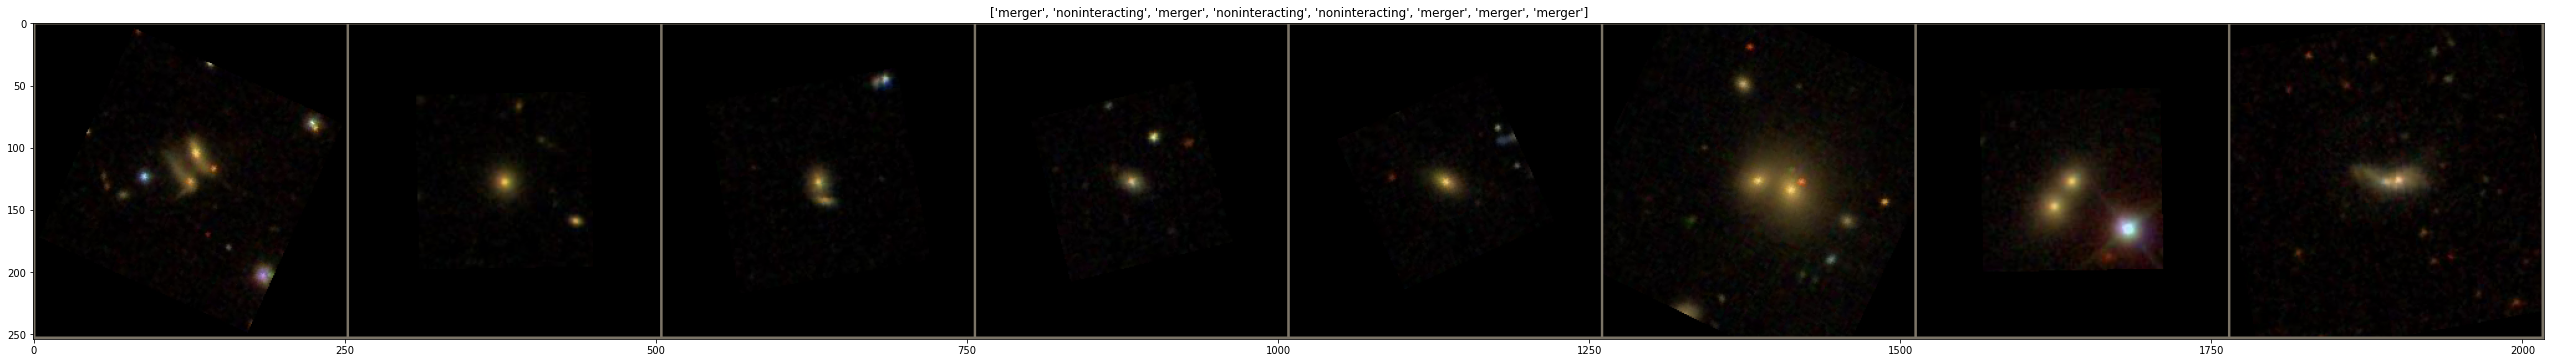

In [13]:
def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.figure(figsize=(45, 90))
  plt.imshow(inp, )
  if title is not None:
      plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
class_names

['merger', 'noninteracting']

In [15]:
dataset_sizes

{'test': 3998, 'train': 8003, 'val': 3999}

In [21]:
model = models.resnet18(pretrained=True)
model = model.to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.fc = model.fc.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
#         self.pool = nn.MaxPool2d(2)
#         self.dropout = nn.Dropout(0.2)
#         self.fc1 = nn.Linear(128, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 2)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.dropout(x)
#         x = self.pool(x)

#         x = F.relu(self.conv2(x))
#         x = self.dropout(x)
#         x = self.pool(x)

#         x = F.relu(self.conv3(x))
#         x = self.dropout(x)
#         x = self.pool(x)

#         x = F.relu(self.conv4(x))
#         x = self.dropout(x)
#         x = self.pool(x)

#         x = torch.flatten(x, 1) # flatten all dimensions except batch

#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# model = Model()
# model = model.to(device)

In [23]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20)  # After every 20 epochs, decrease the lr by `gamma` (= 0.1 by default)

epochs = 50

In [24]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    epochs_no_improve = 0  # Track how many epochs with no decrease in validation loss
    n_epochs_stop = 6  # Stop if no decrement in validation loss after 5 consecutive epochs.
    early_stop = False
    min_val_loss = np.Inf

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):    
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            ### EARLY STOPPING ###
            if phase == "val" and epoch_loss < min_val_loss:
              epochs_no_improve = 0
              min_val_loss = epoch_loss
            elif phase == "val" and epoch_loss >= min_val_loss:
              epochs_no_improve += 1
            
            if epoch > 5 and (epochs_no_improve == n_epochs_stop):
              print("Early stopping!")
              return  # Way to come out of all nested loops
            
            ### end ###

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
trained_model = train_model(model, criterion, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch 0/49
----------
train Loss: 0.4499 Acc: 0.8013
val Loss: 0.3781 Acc: 0.8412

Epoch 1/49
----------
train Loss: 0.3030 Acc: 0.8787
val Loss: 0.9872 Acc: 0.5174

Epoch 2/49
----------
train Loss: 0.2666 Acc: 0.8985
val Loss: 0.2863 Acc: 0.9002

Epoch 3/49
----------
train Loss: 0.2505 Acc: 0.9039
val Loss: 0.2028 Acc: 0.9207

Epoch 4/49
----------
train Loss: 0.2187 Acc: 0.9169
val Loss: 0.8628 Acc: 0.3981

Epoch 5/49
----------
train Loss: 0.2019 Acc: 0.9230
val Loss: 0.2023 Acc: 0.9170

Epoch 6/49
----------
train Loss: 0.1873 Acc: 0.9298
val Loss: 0.2270 Acc: 0.9245

Epoch 7/49
----------
train Loss: 0.1704 Acc: 0.9341
val Loss: 0.2449 Acc: 0.9152

Epoch 8/49
----------
train Loss: 0.1600 Acc: 0.9373
val Loss: 0.2347 Acc: 0.9162

Epoch 9/49
----------
train Loss: 0.1584 Acc: 0.9388
val Loss: 0.1931 Acc: 0.9300

Epoch 10/49
----------
train Loss: 0.1421 Acc: 0.9479
val Loss: 0.1818 Acc: 0.9437

Epoch 11/49
----------
train Loss: 0.1524 Acc: 0.9456
val Loss: 0.1563 Acc: 0.9390

Ep

In [26]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 92.89644822411205


In [27]:
preds_ = np.concatenate([pred.cpu().numpy() for pred in all_preds])

In [28]:
preds_

array([1, 1, 1, ..., 0, 0, 1])

In [29]:
targets_ = np.concatenate([target.cpu().numpy() for target in all_targets])

In [30]:
from sklearn.metrics import  confusion_matrix, classification_report

In [31]:
print(confusion_matrix(targets_, preds_))
print("\n")
print(classification_report(targets_, preds_))

[[1376  122]
 [ 162 2338]]


              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1498
           1       0.95      0.94      0.94      2500

    accuracy                           0.93      3998
   macro avg       0.92      0.93      0.92      3998
weighted avg       0.93      0.93      0.93      3998



In [32]:
!pip install plot-metric

In [33]:
from plot_metric.functions import BinaryClassification

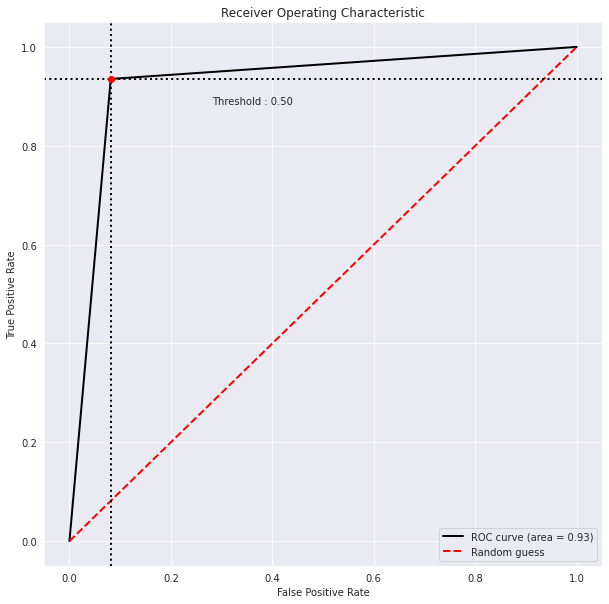

In [34]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds_, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()